# Stick setup

In [1]:
import math
import scipy as sp
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from Additional_functions import dcplot, Imp, Opener, cancel_borders

Now start finding those features on a new image. We want to discover the angle the stick must be turned in order to get the logo straight visible. There's a problem with homographies: the stick is a cylindrical object but the homographies deals with planes. The homography finds the plane correspondent to one of the four side. In such a way we are approximating the cylindrical object into a parallelepipedo. So, after initializing the SIFT and computing all the feature belonging to a side, we will look for them into the real image of the stick. In such a way we find a "reference" side from which we can compute the overall rotation needed. We take as an example, one of the thughest image to compute its orientation.

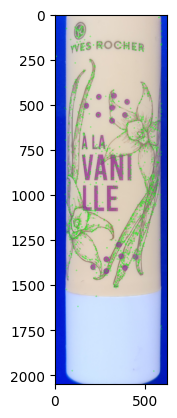

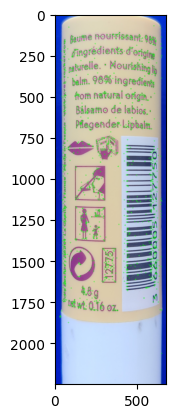

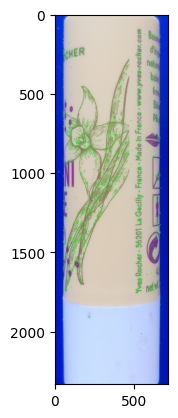

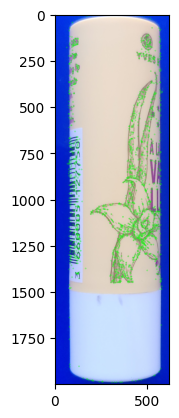

In [2]:
sift = []
query = []
FLANN_INDEX_KDTREE = 1
MIN_MATCH_COUNT = 100
des_query = []

front, FRONT, filfront, FILFRONT = Imp("Photos/Stick/Query_front.jpg")
back,BACK, filback, FILBACK = Imp("Photos/Stick/Query_back.jpg")
side1, SIDE1, filside1, FILSIDE1 = Imp("Photos/Stick/query_side_ccw.jpg")
side2, SIDE2, filside2, FILSIDE2 = Imp("Photos/Stick/query_side_cw.jpg")

images = [FILFRONT, FILBACK, FILSIDE1, FILSIDE2]
gray_images = [front, back, side1, side2]

for i in range(0, 4, 1):
    siftis = cv2.xfeatures2d.SIFT_create()
    sift.append(siftis)
    kp_query = siftis.detect(images[i])
    kp_query, desimg_query = siftis.compute(images[i], kp_query)
    query.append(kp_query)
    des_query.append(desimg_query)
    img_visualization = cv2.drawKeypoints(images[i],kp_query, outImage = True, color = (0, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    plt.imshow(img_visualization)
    plt.show()
    

Now start to look for one of this sides. First of all we print out the number of feature. In this way we can break the for when we see that there's a number of match close to the total of one side: in that way we could save some computation effort

In [3]:
print(np.size(query[0]))
print(np.size(query[1]))
print(np.size(query[2]))
print(np.size(query[3]))

1745
2721
2658
2057


And now the function where we compute the correspondence between one of the four face: we don't simply choose the side with the most correspondences but the side with the highest percentage of correspondences; in that way we don't penalize the side with less correspondences. Then compute the homography and from that the orientation 

[0.2521489971346705, 0, 0, 0]
Frontal correspondences are: 440
440
[0.2521489971346705, 0.1113561190738699, 0, 0]
303
[0.2521489971346705, 0.1113561190738699, 0.1655379984951091, 0]
440
[0.2521489971346705, 0.1113561190738699, 0.1655379984951091, 0.09722897423432182]
200


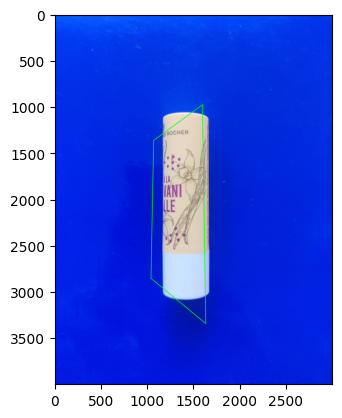

In [5]:
stick, STICK, filstick, FILSTICK = Imp("Photos/Stick/S9.jpg")
#initialize vectors of the keypoints
kp_train = []
des_train = []
matches = []
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
percentages = [0,0,0,0]
#For loop where I compute for one of each of the four side the matches
for i in range (0, 4, 1):
    train = sift[i].detect(FILSTICK)
    train, d_train = sift[i].compute(FILSTICK, train)
    kp_train.append(train)
    des_train.append(d_train)
    match = flann.knnMatch(des_query[i], des_train[i], k = 2)
    matches.append(match)
    good = []
    
    for m,n in matches[i]:
        if m.distance < 0.8*n.distance:
            good.append(m)

    percentages[i] = len(good)/np.size(query[i])
    print(percentages)
    if i == 0:
        good_best = good
        index = 0
        print("Frontal correspondences are:", len(good))
        
    elif i > 0:
        if percentages[i] == np.max(percentages): #Best sides become another
            good_best = good
            print("Now the side with most correspondences is the", i)
            index = i

    if len(good_best) >= 0.75*len(query[i]): #Enough matches 
        break
    print(len(good))

h, w = np.shape(gray_images[index])
#We find the homography with respect to the side with most correspondences -> good_best
if len(good_best) > MIN_MATCH_COUNT:
    ngood = []
    for m,n in matches[index]:
        if m.distance < 0.8*n.distance:
            ngood.append(m)

    src_pts = np.float32([ query[index][m.queryIdx].pt for m in ngood ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[index][m.trainIdx].pt for m in ngood ]).reshape(-1,1,2)
    M1, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 24.0)
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M1)
    #Finally draw the boundary lines
    PIC = cv2.polylines(FILSTICK, [np.int32(dst)], True, (0,255, 0), 5, cv2.LINE_AA)

plt.imshow(PIC)
plt.show()


Despite the lateral side gives more correspondences, the percentage of feature is higher for the frontal side, and in fact altough the image is oriented between the frontal and lateral it looks closer to the frontal side. Of course we want to compute the homography as accurately as possible because from that depends the accuracy of the orientation found. 

In [6]:
print(M1)
#We find the rotation angle from the angle detected by the homography
rotation_angle_rad = np.arctan2(M1[1, 0], M1[0, 0])
rotation_angle_deg = np.int32(np.degrees(rotation_angle_rad))
print(rotation_angle_deg)

[[-5.17879893e-02 -5.86022549e-02  1.06484149e+03]
 [-1.17314939e+00  6.05494744e-01  1.36609682e+03]
 [-5.64739504e-04 -4.28679700e-05  1.00000000e+00]]
-92


Why do I compute it using the first two terms $H_{11}$ and $H_{12}$ of the homography? Those are the terms that says how much x and y of the reference image affects x in the  final image. In fact, if we consider the z axis entering the image, x representing the horizontal axis and y the vertical axes, we note that rotating the stick, we are rotating it along y (that depends of course on how the image are taken, if I had taken images with the stick placed horizontally, that would be the opposite). So rotating it, there's basically no difference of height of the pixel (actually there's a little due to the differnce in depth when rotating an object), but there's a difference in x. 

# Integrity
Now let's check the two cases of integrity: the one where there's not the white part and the one when there's only the white part. Given that the discriminance to establish the presence of defects is the present of white

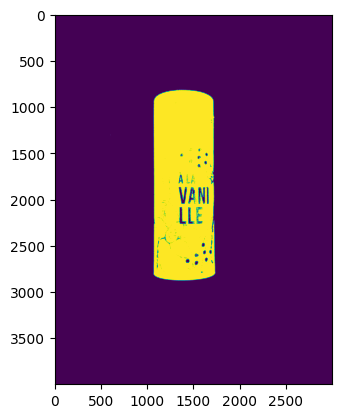

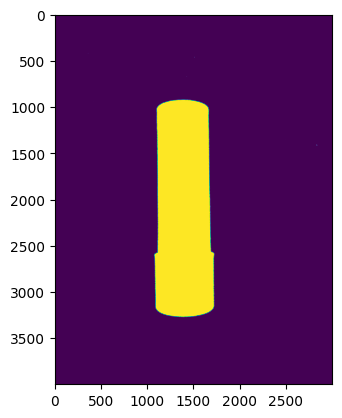

In [7]:
#Import the image where there are defects
d1, D1, fild1, FILD1 = Imp("Photos/Stick/S11.jpg")
w1, W1, filw1, FILW1 = Imp("Photos/Stick/S20.jpg")

#let's try a high and binary threshold in such a way to isolate the brighter parts
#see how perform with both images
twhite = 180
thresh = cv2.threshold(d1, twhite,  255, cv2.THRESH_OTSU)[1]
thresh2 = cv2.threshold(w1, twhite, 255, cv2.THRESH_OTSU)[1]
plt.imshow(thresh)
plt.show()

plt.imshow(thresh2)
plt.show()




With binarization we are able to see the the shape of the image. From that, if there's no variation inside we know it's the defect where we miss the yellow part. Instead, we can find the defect where there's no white by analizing the lower part: we cut the image with the boundary founded previously (in fact if there's the upper part the product is detected anyway) and if the lower part is "black" there's not the white part -> product defectful

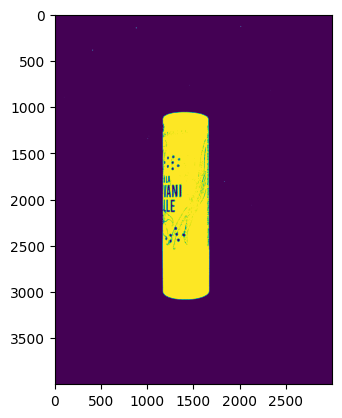

[[1064.8414 1366.0968]
 [1035.7413 2857.7722]
 [1626.9576 3346.535 ]
 [1591.7656  980.9873]]


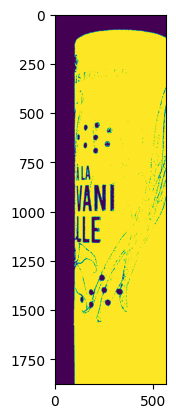

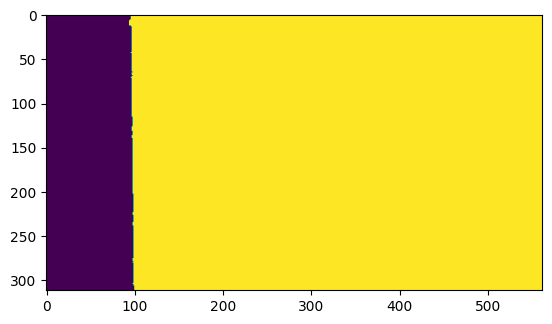

In [8]:
thresh3 = cv2.threshold(filstick,0, 255, cv2.THRESH_OTSU)[1]

plt.imshow(thresh3)
plt.show()
dst = dst.reshape(4,2)
print(dst)
dstint = np.int32(dst)
stick_thresh = thresh3[dstint[3,1]:dstint[1,1], dstint[0,0]:dstint[2,0]]
plt.imshow(stick_thresh)
plt.show()
h_stick, w_stick = np.shape(stick_thresh)
lower_part_coefficient = 6
lower_part = stick_thresh[-np.int32(h_stick/lower_part_coefficient):,:]

#Plot just the lower part to see wheter there's something bright or not
plt.imshow(lower_part)
plt.show()

check_white = np.sum(lower_part == 255)
if check_white <= 10000:
    ("there's not the white part, product defective")

# To reduce the computations
Given that the overall procedure is very expensive in terms of computation, if necessary, we can implement techniques to reduce it. For example reducing the area to analize by cutting out the stick from the image with a connected component algorithm. In fact, even if the connected component procedure is itself computationally expensive, after that, we could compute the 4 sides correspondences in a narrower area. My original idea was to have just two sides as a refernce (the front and the back) and compute the orientation from those, but with 4 is incredibly more accurated especially in the case where there's a "lateral" view of the stick.